# Generating SQL for SQLite using Ollama, ChromaDB
This notebook runs through the process of using the `vanna` Python package to generate SQL using AI (RAG + LLMs) including connecting to a database and training. If you're not ready to train on your own database, you can still try it using a sample [SQLite database](app.md).

## Setup

In [1]:
import warnings
import re

warnings.filterwarnings('ignore', category=DeprecationWarning, message='^Number of requested results')
# warnings.filterwarnings('ignore', category=DeprecationWarning, message=re.escape(r'^Some regex pattern'))

import os

import re
from time import time
from datetime import datetime 

from vanna.ollama import Ollama
from vanna.chromadb.chromadb_vector import ChromaDB_VectorStore

In [2]:
model_name = 'deepseek-coder-v2' # "codegeex4" # "llama3" # "qwen2.5" # 
CONFIG = {
    'model': model_name,   
}

file_db = "~/Downloads/datasets/chinook.db"


clean_and_train = True  # False  

sql_id = 1

allow_llm_to_see_data = True
# allow_llm_to_see_data (bool): Whether to allow the LLM to see the data (for the purposes of introspecting the data to generate the final SQL).

In [3]:
class MyVanna(ChromaDB_VectorStore, Ollama):
    def __init__(self, config=None):
        ChromaDB_VectorStore.__init__(self, config=config)
        Ollama.__init__(self, config=config)

In [4]:
vn = MyVanna(config=CONFIG)

In [5]:
hostname = os.uname().nodename
print("Hostname:", hostname)

Hostname: papa-game


In [6]:
file_db = os.path.abspath(os.path.expanduser(file_db))
vn.connect_to_sqlite(file_db)

In [7]:
vn.run_sql_is_set

True

In [8]:
if clean_and_train:
    vn.remove_collections()

## Training

### [SQLite sample database](https://www.sqlitetutorial.net/sqlite-sample-database/)

You only need to train once. Do not train again unless you want to add more training data.

In [9]:
df_ddl = vn.run_sql("SELECT type, sql FROM sqlite_master WHERE sql is not null")

In [10]:
df_ddl

,type,sql
0,table,CREATE TABLE [Album]\n(\n [AlbumId] INTEGER...
1,table,CREATE TABLE [Artist]\n(\n [ArtistId] INTEG...
2,table,CREATE TABLE [Customer]\n(\n [CustomerId] I...
3,table,CREATE TABLE [Employee]\n(\n [EmployeeId] I...
4,table,CREATE TABLE [Genre]\n(\n [GenreId] INTEGER...
5,table,CREATE TABLE [Invoice]\n(\n [InvoiceId] INT...
6,table,CREATE TABLE [InvoiceLine]\n(\n [InvoiceLin...
7,table,CREATE TABLE [MediaType]\n(\n [MediaTypeId]...
8,table,CREATE TABLE [Playlist]\n(\n [PlaylistId] I...
9,table,CREATE TABLE [PlaylistTrack]\n(\n [Playlist...


In [11]:
if clean_and_train:
    for ddl in df_ddl['sql'].to_list():
        # ddl = strip_brackets(ddl)
        vn.train(ddl=ddl)

    # Sometimes you may want to add documentation about your business terminology or definitions.
    vn.train(documentation="In the chinook database invoice means order")

    doc_str = """
    In the 'customers' table, address column names do not have 'Billing' prefix, 
    e.g. country column name is 'country', not 'BillingCountry'
    """
    vn.train(documentation=doc_str)


Adding ddl: CREATE TABLE [Album]
(
    [AlbumId] INTEGER  NOT NULL,
    [Title] NVARCHAR(160)  NOT NULL,
    [ArtistId] INTEGER  NOT NULL,
    CONSTRAINT [PK_Album] PRIMARY KEY  ([AlbumId]),
    FOREIGN KEY ([ArtistId]) REFERENCES [Artist] ([ArtistId]) 
		ON DELETE NO ACTION ON UPDATE NO ACTION
)
Adding ddl: CREATE TABLE [Artist]
(
    [ArtistId] INTEGER  NOT NULL,
    [Name] NVARCHAR(120),
    CONSTRAINT [PK_Artist] PRIMARY KEY  ([ArtistId])
)
Adding ddl: CREATE TABLE [Customer]
(
    [CustomerId] INTEGER  NOT NULL,
    [FirstName] NVARCHAR(40)  NOT NULL,
    [LastName] NVARCHAR(20)  NOT NULL,
    [Company] NVARCHAR(80),
    [Address] NVARCHAR(70),
    [City] NVARCHAR(40),
    [State] NVARCHAR(40),
    [Country] NVARCHAR(40),
    [PostalCode] NVARCHAR(10),
    [Phone] NVARCHAR(24),
    [Fax] NVARCHAR(24),
    [Email] NVARCHAR(60)  NOT NULL,
    [SupportRepId] INTEGER,
    CONSTRAINT [PK_Customer] PRIMARY KEY  ([CustomerId]),
    FOREIGN KEY ([SupportRepId]) REFERENCES [Employee] ([Emp

In [12]:
# show training data
training_data = vn.get_training_data()
training_data

,id,question,content,training_data_type
0,00e3136b-f688-5ae4-a2bb-3354635261fc-ddl,None,CREATE INDEX IFK_CustomerSupportRepId ON Custo...,ddl
1,04a3d9eb-fab7-5641-96a1-ae7924ae05e5-ddl,None,CREATE INDEX IFK_EmployeeReportsTo ON Employee...,ddl
2,11439f95-bfbc-530c-8b7f-91f9e45d2877-ddl,None,CREATE TABLE Track\n(\n TrackId INTEGER NO...,ddl
3,29f57d6d-552a-5cc2-8c8c-cb78918d1646-ddl,None,CREATE TABLE Genre\n(\n GenreId INTEGER NO...,ddl
4,33d9efb0-969c-59b8-95f1-04b3e0ddd2df-ddl,None,CREATE INDEX IFK_TrackAlbumId ON Track (AlbumId),ddl
5,37bc3b25-2dc1-5160-bcae-baf85b93f023-ddl,None,CREATE TABLE InvoiceLine\n(\n InvoiceLineId...,ddl
6,4893f9e4-2275-53cb-89da-43de3063acf1-ddl,None,CREATE TABLE PlaylistTrack\n(\n PlaylistId ...,ddl
7,82dfbbaf-4fe6-5213-8c5a-2e765f459ca1-ddl,None,CREATE TABLE Artist\n(\n ArtistId INTEGER ...,ddl
8,8a3cbf5f-a4d9-5429-93de-e49ef72c5bd5-ddl,None,CREATE TABLE Customer\n(\n CustomerId INTEG...,ddl
9,93344862-5b4e-5a02-8c70-982b08c6badf-ddl,None,CREATE INDEX IFK_InvoiceLineInvoiceId ON Invoi...,ddl


## Asking the AI
Whenever you ask a new question, it will find the 10 most relevant pieces of training data and use it as part of the LLM prompt to generate the SQL.

### warm-up

In [ ]:
ts_start = time()
question = "How many customers are there"
resp = vn.ask_adaptive(question=question)
ts_stop = time()
elapsed_time = ts_stop - ts_start
print(f"elapsed_time = {elapsed_time}")

```sql

SELECT name FROM sqlite_master WHERE type = 'table';

```

```sql

SELECT c.CustomerId, SUM(il.Quantity) AS TotalAlbums
FROM Customers c
JOIN invoices i  ON c.CustomerId = i.CustomerId
JOIN invoice_items il ON i.InvoiceId = il.InvoiceId
GROUP BY c.CustomerId
ORDER BY TotalAlbums DESC
LIMIT 5

```


In [14]:
questions = [
    "Can you list all tables in the SQLite database catalog?",
    "which table stores customer's orders",
    "How many customers are there",
    "what are the top 5 countries that customers come from?",
    "List all albums and their corresponding artist names  ",
    """Find all tracks with a name containing "What" (case-insensitive) """,
    "Get the total number of invoices for each customer",
    "Find the total number of invoices per country",
    "List all invoices with a total exceeding $10",
    "Find all invoices since 2010 and the total amount invoiced:",
    "List all employees and their reporting manager's name (if any):",
    " Get the average invoice total for each customer:",
    "Find the top 5 most expensive tracks (based on unit price):",
    "List all genres and the number of tracks in each genre:",
    "Get all genres that do not have any tracks associated with them:",
    "List all customers who have not placed any orders:",
    """ 
        Can you find the top 10 most popular artists based on the number of tracks?
        Hint: There are 3 tables - artists, albums and tracks, 
        where albums and artists are linked by ArtistId, albums and tracks are linked by AlbumId,
    """,
    "List all customers from Canada and their email addresses:",
    "Find the customer with the most invoices ",
    "Find the customer who bought the most albums in total quantity (across all invoices):",
    """      
        Find the top 5 customers who bought the most albums in total quantity (across all invoices):
        Hint: album quantity is found in invoice_items, 
    """,
    """  
         Find the top 5 customers who spent the most money overall,  
         Hint: order total can be found on invoices table, calculation using invoice_items detail table is unnecessary 
    """,
    "Get all playlists containing at least 10 tracks and the total duration of those tracks:",
    "Identify artists who have albums with tracks appearing in multiple genres:",
]

### Loop over questions

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 2:  Can you list all tables in the SQLite database catalog?


[( SQL PROMPT )]
[{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE Playlist\n(\n    PlaylistId INTEGER  NOT NULL,\n    Name NVARCHAR(120),\n    CONSTRAINT PK_Playlist PRIMARY KEY  (PlaylistId)\n)\n\nCREATE TABLE Track\n(\n    TrackId INTEGER  NOT NULL,\n    Name NVARCHAR(200)  NOT NULL,\n    AlbumId INTEGER,\n    MediaTypeId INTEGER  NOT NULL,\n    GenreId INTEGER,\n    Composer NVARCHAR(220),\n    Milliseconds INTEGER  NOT NULL,\n    Bytes INTEGER,\n    UnitPrice NUMERIC(10,2)  NOT NULL,\n    CONSTRAINT PK_Track PRIMARY KEY  (TrackId),\n    FOREIGN KEY (AlbumId) REFERENCES Album (AlbumId) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\n    FOREIGN KEY (GenreId) REFERENCES Genre (GenreId) \n\t\tON DELETE

SELECT name FROM sqlite_master WHERE type='table'


[( <DF> )]
queried dataframe


,name
0,Album
1,Artist
2,Customer
3,Employee
4,Genre
5,Invoice
6,InvoiceLine
7,MediaType
8,Playlist
9,PlaylistTrack



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <PYTHON> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(mode="number", value=df['name'].iloc[0]))
else:
    fig = go.Figure(data=[go.Table(header=dict(values=list(df.columns)), cells=dict(values=[df['name']]))])

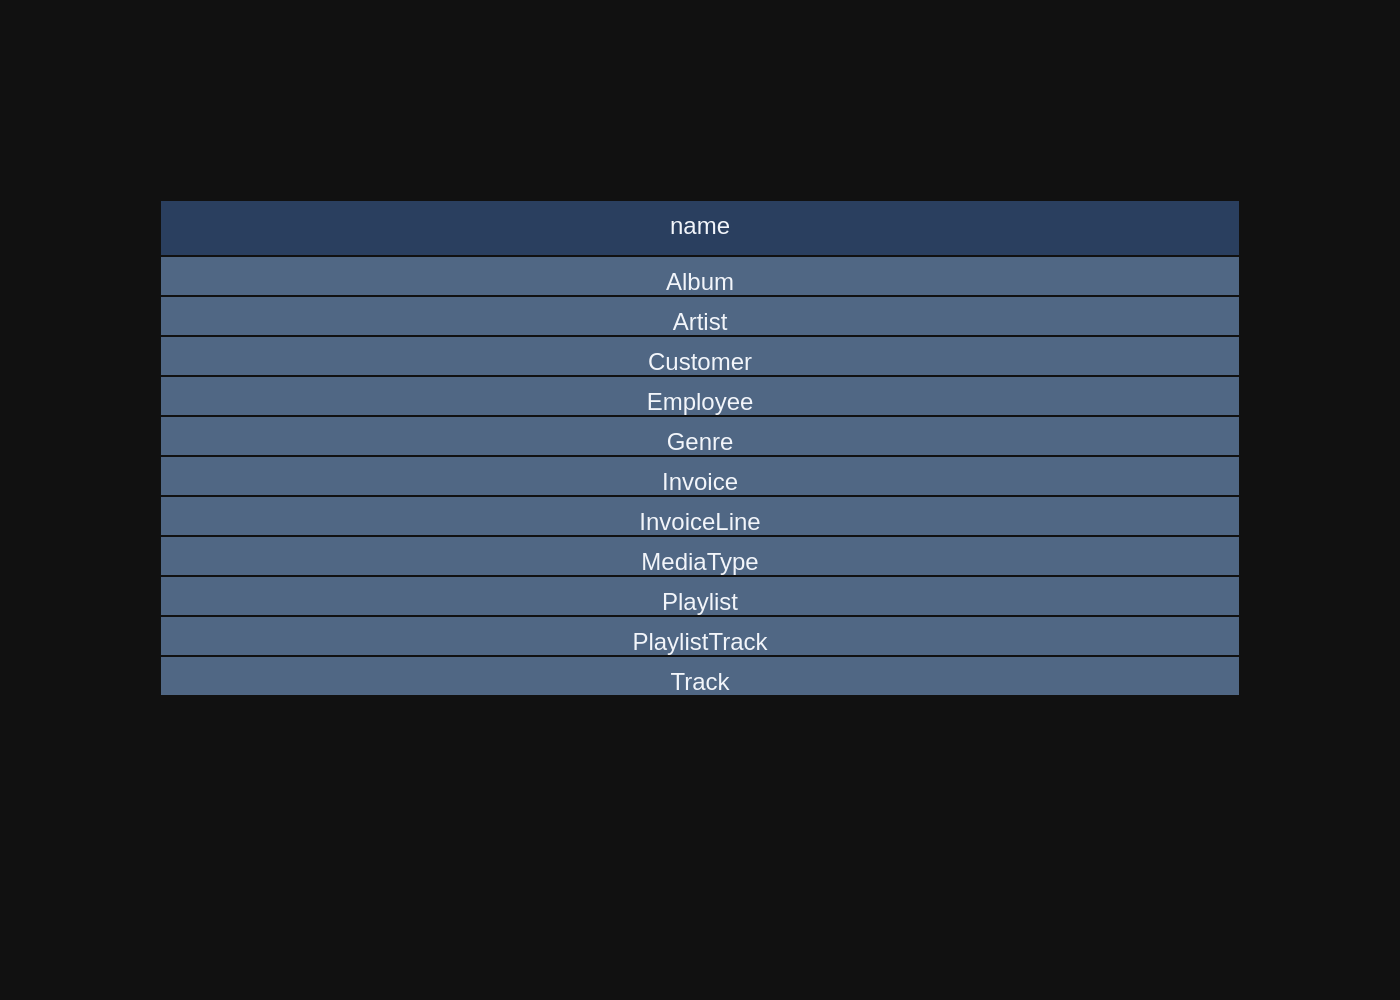

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 3:  which table stores customer's orders


[( SQL PROMPT )]
[{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE Customer\n(\n    CustomerId INTEGER  NOT NULL,\n    FirstName NVARCHAR(40)  NOT NULL,\n    LastName NVARCHAR(20)  NOT NULL,\n    Company NVARCHAR(80),\n    Address NVARCHAR(70),\n    City NVARCHAR(40),\n    State NVARCHAR(40),\n    Country NVARCHAR(40),\n    PostalCode NVARCHAR(10),\n    Phone NVARCHAR(24),\n    Fax NVARCHAR(24),\n    Email NVARCHAR(60)  NOT NULL,\n    SupportRepId INTEGER,\n    CONSTRAINT PK_Customer PRIMARY KEY  (CustomerId),\n    FOREIGN KEY (SupportRepId) REFERENCES Employee (EmployeeId) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)\n\nCREATE TABLE Invoice\n(\n    InvoiceId INTEGER  NOT NULL,\n    CustomerId INTEGER  NOT NULL,\n    I

Number of requested results 10 is greater than number of elements in index 1, updating n_results = 1
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( LLM RESPONSE )]
 The `Invoice` table stores customer's orders.

[( RETRY )]
***** 1 *****

[( SQL PROMPT )]
[{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE Invoice\n(\n    InvoiceId INTEGER  NOT NULL,\n    CustomerId INTEGER  NOT NULL,\n    InvoiceDate DATETIME  NOT NULL,\n    BillingAddress NVARCHAR(70),\n    BillingCity NVARCHAR(40),\n    BillingState NVARCHAR(40),\n    BillingCountry NVARCHAR(40),\n    BillingPostalCode NVARCHAR(10),\n    Total NUMERIC(10,2)  NOT NULL,\n    CONSTRAINT PK_Invoice PRIMARY KEY  (InvoiceId),\n    FOREIGN KEY (CustomerId) REFERENCES Customer (CustomerId) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)\n\nCREATE TABLE InvoiceLine\n(\n    InvoiceLineId INTEGER  NOT NULL,\n    InvoiceId INTEGER  NOT NULL,\n    TrackId INTEGER  NOT NULL,\n    Un

SELECT name FROM sqlite_master WHERE type='table'


[( <DF> )]
queried dataframe


,name
0,Album
1,Artist
2,Customer
3,Employee
4,Genre
5,Invoice
6,InvoiceLine
7,MediaType
8,Playlist
9,PlaylistTrack



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <PYTHON> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame and it contains at least two columns for plotting purposes (e.g., 'name' and 'value')
if len(df) == 1:
    fig = go.Figure(data=[go.Indicator(mode="number", value=df['name'].iloc[0])])
else:
    fig = px.bar(df, x='name', y='value', labels={'name':'Name', 'value':'Value'})

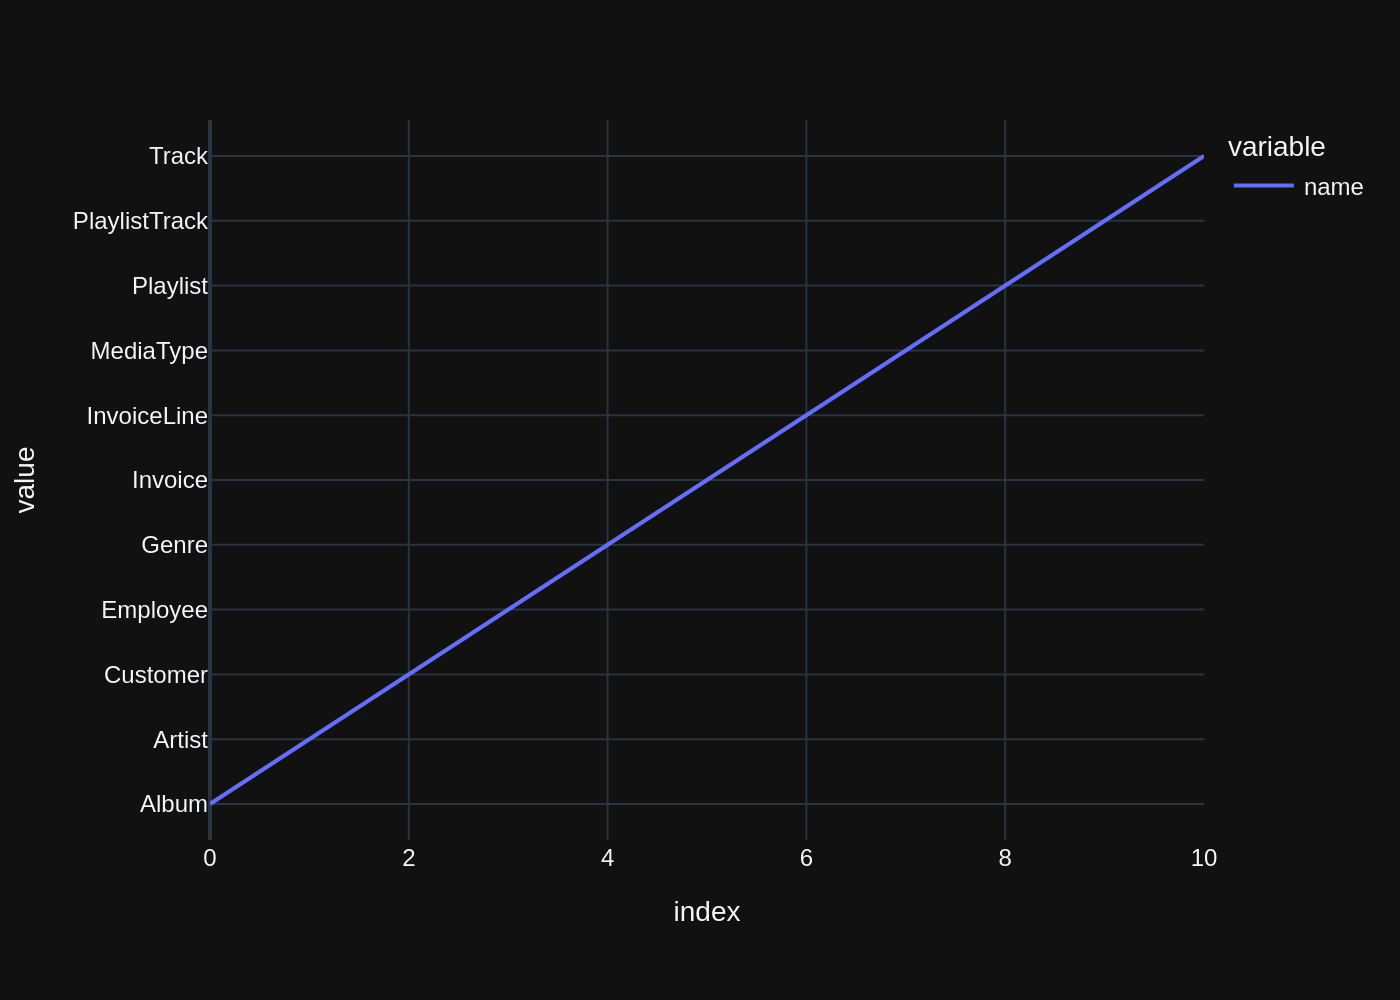

Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 4:  How many customers are there


[( SQL PROMPT )]
[{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE Customer\n(\n    CustomerId INTEGER  NOT NULL,\n    FirstName NVARCHAR(40)  NOT NULL,\n    LastName NVARCHAR(20)  NOT NULL,\n    Company NVARCHAR(80),\n    Address NVARCHAR(70),\n    City NVARCHAR(40),\n    State NVARCHAR(40),\n    Country NVARCHAR(40),\n    PostalCode NVARCHAR(10),\n    Phone NVARCHAR(24),\n    Fax NVARCHAR(24),\n    Email NVARCHAR(60)  NOT NULL,\n    SupportRepId INTEGER,\n    CONSTRAINT PK_Customer PRIMARY KEY  (CustomerId),\n    FOREIGN KEY (SupportRepId) REFERENCES Employee (EmployeeId) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)\n\nCREATE INDEX IFK_CustomerSupportRepId ON Customer (SupportRepId)\n\nCREATE TABLE Invoice\n(\n    InvoiceId 

SELECT COUNT(*) AS NumberOfCustomers FROM Customer


[( <DF> )]
queried dataframe


,NumberOfCustomers
0,59



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <PYTHON> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['NumberOfCustomers'].values[0],
        title={"text": "Number of Customers"}
    ))
else:
    fig = go.Figure(go.Bar(
        x=['NumberOfCustomers'],
        y=[df['NumberOfCustomers'].values[0]]
    ))

fig.update_layout(title='Number of Customers')

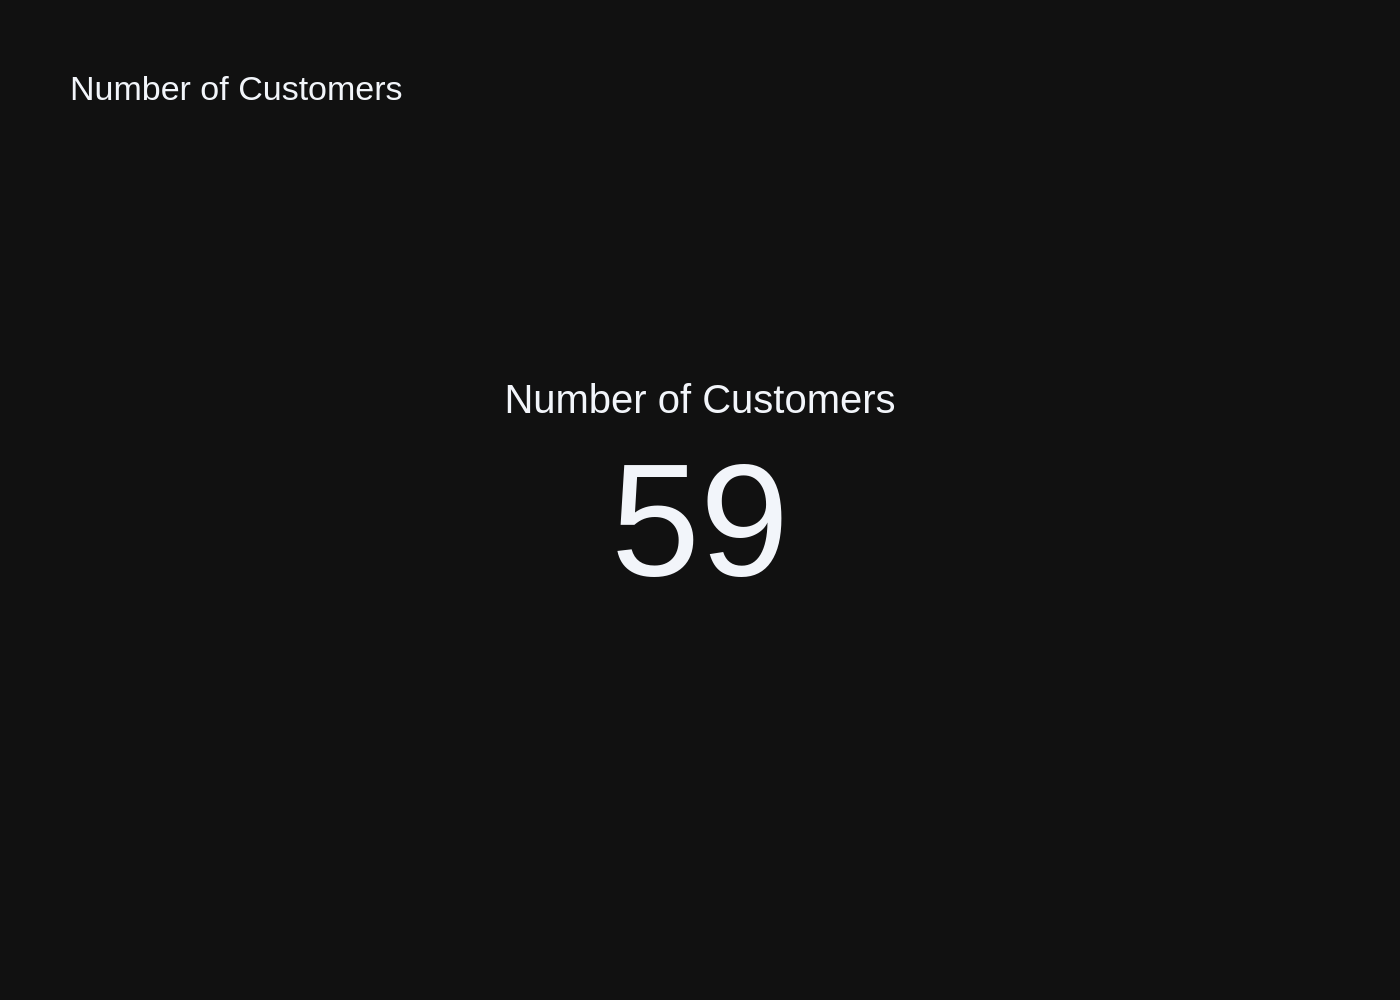

Number of requested results 10 is greater than number of elements in index 3, updating n_results = 3




# QUESTION - 5:  what are the top 5 countries that customers come from?



Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2



[( SQL PROMPT )]
[{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE TABLE Customer\n(\n    CustomerId INTEGER  NOT NULL,\n    FirstName NVARCHAR(40)  NOT NULL,\n    LastName NVARCHAR(20)  NOT NULL,\n    Company NVARCHAR(80),\n    Address NVARCHAR(70),\n    City NVARCHAR(40),\n    State NVARCHAR(40),\n    Country NVARCHAR(40),\n    PostalCode NVARCHAR(10),\n    Phone NVARCHAR(24),\n    Fax NVARCHAR(24),\n    Email NVARCHAR(60)  NOT NULL,\n    SupportRepId INTEGER,\n    CONSTRAINT PK_Customer PRIMARY KEY  (CustomerId),\n    FOREIGN KEY (SupportRepId) REFERENCES Employee (EmployeeId) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)\n\nCREATE TABLE Invoice\n(\n    InvoiceId INTEGER  NOT NULL,\n    CustomerId INTEGER  NOT NULL,\n    InvoiceDate DATETIME  NOT NULL,\n    BillingAddress NVARCH

SELECT Country, COUNT(*) AS CustomerCount
FROM Customer
GROUP BY Country
ORDER BY CustomerCount DESC
LIMIT 5


[( <DF> )]
queried dataframe


,Country,CustomerCount
0,USA,13
1,Canada,8
2,France,5
3,Brazil,5
4,Germany,4



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <PYTHON> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Check if the DataFrame has multiple rows
if len(df) > 1:
    fig = go.Figure(data=[go.Bar(x=df['Country'], y=df['CustomerCount'])])
else:
    fig = go.Figure(data=[go.Indicator(value=df['CustomerCount'][0], title={"text": "Total Customers"}, number={'font': {'size': 24}})] )

fig.update_layout(title='Top 5 Countries by Customer Count', xaxis_title='Country', yaxis_title='Number of Customers')

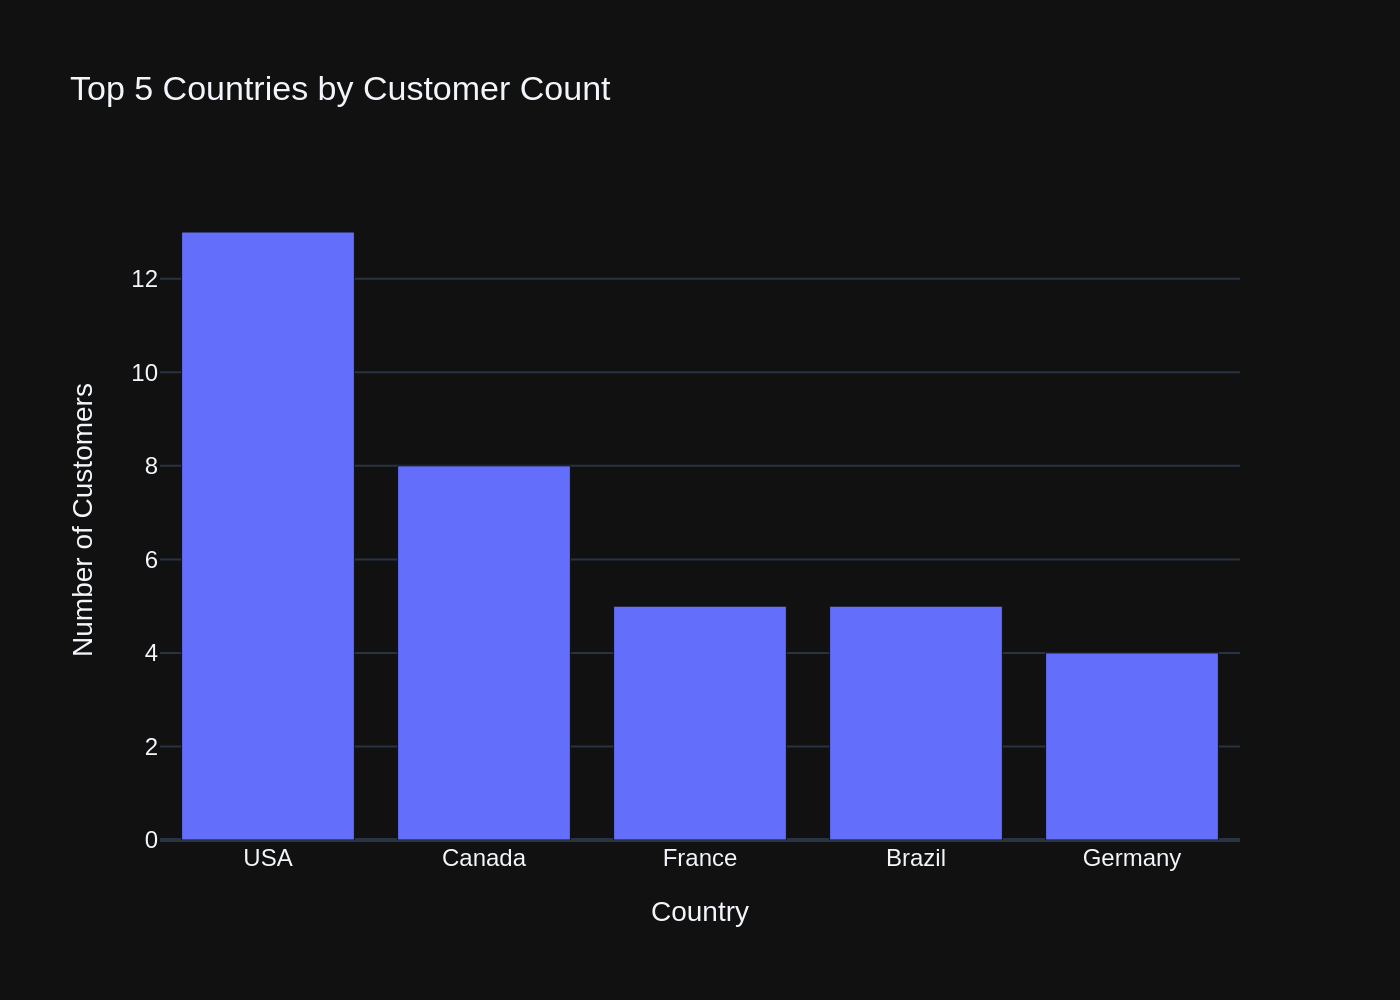

Number of requested results 10 is greater than number of elements in index 4, updating n_results = 4
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 6:  List all albums and their corresponding artist names  


[( SQL PROMPT )]
[{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE INDEX IFK_AlbumArtistId ON Album (ArtistId)\n\nCREATE TABLE Album\n(\n    AlbumId INTEGER  NOT NULL,\n    Title NVARCHAR(160)  NOT NULL,\n    ArtistId INTEGER  NOT NULL,\n    CONSTRAINT PK_Album PRIMARY KEY  (AlbumId),\n    FOREIGN KEY (ArtistId) REFERENCES Artist (ArtistId) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION\n)\n\nCREATE TABLE Track\n(\n    TrackId INTEGER  NOT NULL,\n    Name NVARCHAR(200)  NOT NULL,\n    AlbumId INTEGER,\n    MediaTypeId INTEGER  NOT NULL,\n    GenreId INTEGER,\n    Composer NVARCHAR(220),\n    Milliseconds INTEGER  NOT NULL,\n    Bytes INTEGER,\n    UnitPrice NUMERIC(10,2)  NOT NULL,\n    CONSTRAINT PK_Track PRIMA

SELECT Album.Title AS AlbumTitle, Artist.Name AS ArtistName
FROM Album
JOIN Artist ON Album.ArtistId = Artist.ArtistId


[( <DF> )]
queried dataframe


,AlbumTitle,ArtistName
0,For Those About To Rock We Salute You,AC/DC
1,Balls to the Wall,Accept
2,Restless and Wild,Accept
3,Let There Be Rock,AC/DC
4,Big Ones,Aerosmith
...,...,...
342,Respighi:Pines of Rome,Eugene Ormandy
343,Schubert: The Late String Quartets & String Qu...,Emerson String Quartet
344,Monteverdi: L'Orfeo,"C. Monteverdi, Nigel Rogers - Chiaroscuro; Lon..."
345,Mozart: Chamber Music,Nash Ensemble



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <PYTHON> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Assuming df is your DataFrame
if len(df) == 1:
    fig = go.Figure(data=[go.Indicator(mode="number", value=len(df), title={"text": "Number of Albums"})])
else:
    fig = go.Figure(data=[go.Bar(x=df['AlbumTitle'], y=df['ArtistName'])])

fig.update_layout(title='Albums and Their Artists')

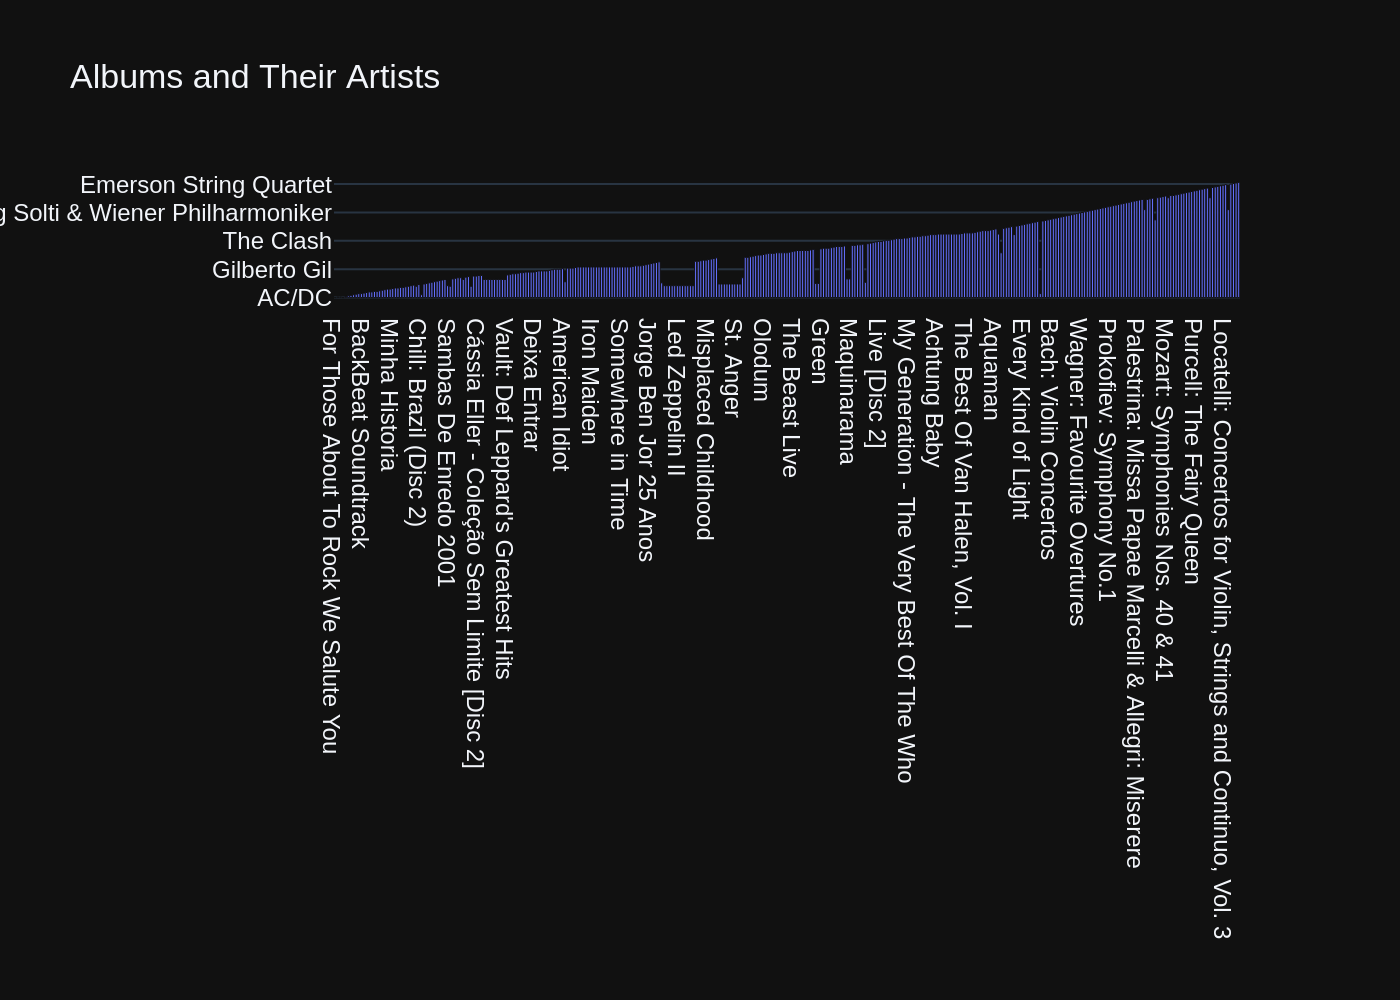

Number of requested results 10 is greater than number of elements in index 5, updating n_results = 5
Number of requested results 10 is greater than number of elements in index 2, updating n_results = 2




# QUESTION - 7:  Find all tracks with a name containing "What" (case-insensitive) 


[( SQL PROMPT )]
[{'role': 'system', 'content': "You are a SQLite expert. Please help to generate a SQL query to answer the question. Your response should ONLY be based on the given context and follow the response guidelines and format instructions. \n===Tables \nCREATE INDEX IFK_TrackGenreId ON Track (GenreId)\n\nCREATE TABLE Track\n(\n    TrackId INTEGER  NOT NULL,\n    Name NVARCHAR(200)  NOT NULL,\n    AlbumId INTEGER,\n    MediaTypeId INTEGER  NOT NULL,\n    GenreId INTEGER,\n    Composer NVARCHAR(220),\n    Milliseconds INTEGER  NOT NULL,\n    Bytes INTEGER,\n    UnitPrice NUMERIC(10,2)  NOT NULL,\n    CONSTRAINT PK_Track PRIMARY KEY  (TrackId),\n    FOREIGN KEY (AlbumId) REFERENCES Album (AlbumId) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\n    FOREIGN KEY (GenreId) REFERENCES Genre (GenreId) \n\t\tON DELETE NO ACTION ON UPDATE NO ACTION,\n    FOREIGN KEY (MediaTypeId) REFERENCES MediaType

SELECT * FROM Track
WHERE LOWER(Name) LIKE '%what%'


[( <DF> )]
queried dataframe


,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,26,What It Takes,5,1,1,"Steven Tyler, Joe Perry, Desmond Child",310622,10144730,0.99
1,88,What You Are,10,1,1,Audioslave/Chris Cornell,249391,5988186,0.99
2,130,Do what cha wanna,13,1,2,George Duke,274155,9018565,0.99
3,342,What is and Should Never Be,30,1,1,Jimmy Page/Robert Plant,260675,8497116,0.99
4,607,So What,48,1,2,Miles Davis,564009,18360449,0.99
5,960,What A Day,76,1,1,"Mike Bordin, Billy Gould, Mike Patton",158275,5203430,0.99
6,1000,What If I Do?,80,1,1,"Dave Grohl, Taylor Hawkins, Nate Mendel, Chris...",302994,9929799,0.99
7,1039,What Now My Love,83,1,12,carl sigman/gilbert becaud/pierre leroyer,149995,4913383,0.99
8,1145,Whatsername,89,1,4,Green Day,252316,8244843,0.99
9,1440,"Whatever It Is, I Just Can't Stop",116,1,1,"Jay Kay/Kay, Jay",247222,8249453,0.99



Ollama parameters:
model=deepseek-coder-v2:latest,
options={},
keep_alive=None

[( <PYTHON> )]
generated Plotly code


import plotly.graph_objects as go
import pandas as pd

# Check if the DataFrame has only one row
if df.shape[0] == 1:
    fig = go.Figure(go.Indicator(
        mode="number",
        value=df['TrackId'].iloc[0],
        title={"text": "Total Tracks"},
        domain={'x': [0, 1], 'y': [0, 1]}
    ))
else:
    fig = go.Figure(data=[go.Scatter(x=df['TrackId'], y=df['UnitPrice'], mode='markers')])

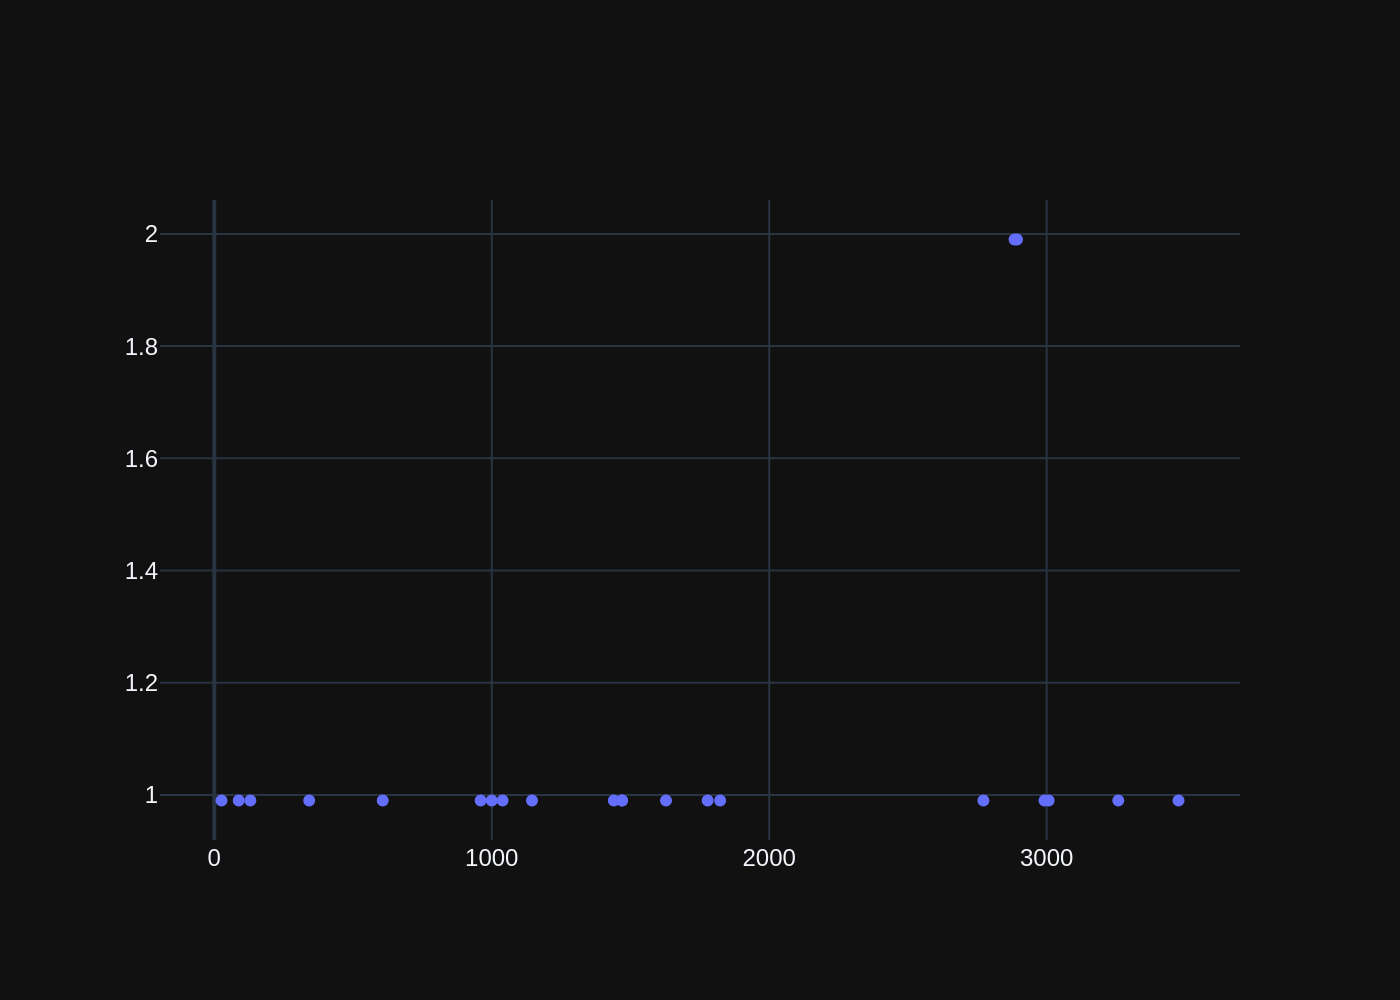

In [15]:
ts_start = time()
for n, question in enumerate(questions):
    # if n != 4: continue
    # if n > 5: continue

    resp = vn.ask_adaptive(question=question, tag_id=n+2)
    # vn.ask(question=question, allow_llm_to_see_data=allow_llm_to_see_data)
    # my_vn_ask(question=question, sql_id=n+2, allow_llm_to_see_data=allow_llm_to_see_data)

ts_stop = time()
elapsed_time = ts_stop - ts_start

### Check completion time

In [16]:
str_elapsed_sec = f"{elapsed_time:.0f}"
ts = datetime.now().strftime("%Y%m%d-%H%M%S")
print(f"Completed testing:\n================\n LLM model '{model_name}' \n took {str_elapsed_sec} sec\n run on '{hostname}' \n at {ts}")

Completed testing:
 LLM model 'deepseek-coder-v2' 
 took 454 sec
 run on 'papa-game' 
 at 20241020-132037


In [17]:
file_csv = f"training_data-{model_name}-{str_elapsed_sec}s-{hostname}-{ts}.csv"
file_csv

'training_data-deepseek-coder-v2-454s-papa-game-20241020-132037.csv'

### Save training data

In [18]:
# show training data
df_training_data = vn.get_training_data()
df_training_data

,id,question,content,training_data_type
0,04a2068e-b7a5-54ce-9269-4fd9b73f337f-sql,List all albums and their corresponding artist...,"SELECT Album.Title AS AlbumTitle, Artist.Name ...",sql
1,19decd16-b8f9-5fb2-ba6e-238ce8b76c06-sql,\n For this question: which tab...,SELECT name FROM sqlite_master WHERE type='table',sql
2,392c8b16-e321-5fe7-a914-7adf3a75a002-sql,what are the top 5 countries that customers co...,"SELECT Country, COUNT(*) AS CustomerCount\nFRO...",sql
3,bd5c3bb4-fc60-507f-af02-28a130bf177c-sql,How many customers are there,SELECT COUNT(*) AS NumberOfCustomers FROM Cust...,sql
4,cf732417-47dd-5588-8216-3791c594a6b2-sql,"Find all tracks with a name containing ""What"" ...",SELECT * FROM Track\nWHERE LOWER(Name) LIKE '%...,sql
5,d8a2f948-dffa-5524-a5f9-174cc1a8da73-sql,Can you list all tables in the SQLite database...,SELECT name FROM sqlite_master WHERE type='table',sql
0,00e3136b-f688-5ae4-a2bb-3354635261fc-ddl,None,CREATE INDEX IFK_CustomerSupportRepId ON Custo...,ddl
1,04a3d9eb-fab7-5641-96a1-ae7924ae05e5-ddl,None,CREATE INDEX IFK_EmployeeReportsTo ON Employee...,ddl
2,11439f95-bfbc-530c-8b7f-91f9e45d2877-ddl,None,CREATE TABLE Track\n(\n TrackId INTEGER NO...,ddl
3,29f57d6d-552a-5cc2-8c8c-cb78918d1646-ddl,None,CREATE TABLE Genre\n(\n GenreId INTEGER NO...,ddl


In [19]:
df_training_data.to_csv(file_csv, index=False)